# Intro

In this notebook, you will find the instructions to download and preprocess the NIH RePORTER dataset starting from 1985.

You will also find the steps to build the tables for a Microsoft SQL Server database that is hosted at OST.

# Download the data

First of all, you need to manually download the CSV files you need and put them in your folder `content/downloads/zipped`. NIH now prevents us from webscraping the files.

* Download the files here: https://reporter.nih.gov/exporter

There is one data dump (i.e. CSV file) per year. Download the files from 1985 to the current year.

# Take a look at the NIH RePORTER documentation

This dataset is quite complex. Please refer to the following links to understand what the fields and acronyms are:

* Fields description: https://report.nih.gov/exporter-data-dictionary
* Glossary: https://grants.nih.gov/grants/glossary.htm
* Activity codes: https://grants.nih.gov/grants/funding/ac_search_results.htm

# Imports and variables

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import zipfile
import csv
import pandas as pd
import itertools
import re
from datetime import datetime
from utils.csv_headers import *
from collections import OrderedDict

In [3]:
CURRENT_PATH = os.getcwd()
UNZIPPED_DIR = os.path.join(CURRENT_PATH,'content/downloads/unzipped')
OUTPUT_FILE = os.path.join(CURRENT_PATH,'content/output_sql.tsv')
ENHANCED_FILE = os.path.join(CURRENT_PATH,'content/enhanced-output_sql.tsv')
TABLE_DIR = os.path.join(CURRENT_PATH,'content/tables/')

# These parameters should work best with Microsoft SQL Server - unfortunately, it doesn't work well with standard CSV files
ENCODING = 'utf-8'
NEWLINE = ''
DELIMITER = '\t'

In [4]:
df = pd.read_csv(ENHANCED_FILE, delimiter=DELIMITER, encoding=ENCODING, low_memory=False)
df.head()

,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,APPLICATION_TYPE_NAME,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,BUDGET_END,CFDA_CODE,...,SERIAL_NUMBER,STUDY_SECTION,STUDY_SECTION_NAME,SUBPROJECT_ID,SUFFIX,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT
0,10229388,P01,AI,5.0,Non-competing continuation,N,07/23/2021,08/01/2021,07/31/2022,NaN,...,60699.0,ZAI1,Special Emphasis Panel,6205.0,NaN,15.0,58228.0,30570.0,NaN,88798.0
1,10229500,P01,AI,5.0,Non-competing continuation,N,07/27/2021,08/01/2021,07/31/2022,NaN,...,89618.0,ZAI1,Special Emphasis Panel,5808.0,NaN,10.0,390000.0,0.0,NaN,390000.0
2,10234175,P20,GM,5.0,Non-competing continuation,N,08/12/2021,07/01/2021,06/30/2022,NaN,...,104316.0,ZGM1,Special Emphasis Panel,6819.0,NaN,7.0,140000.0,77850.0,NaN,217850.0
3,10107767,R21,AI,5.0,Non-competing continuation,N,01/29/2021,02/01/2021,01/31/2022,855.0,...,148877.0,III,Innate Immunity and Inflammation Study Section,NaN,NaN,2.0,150000.0,86250.0,236250.0,NaN
4,10144347,R01,AG,5.0,Non-competing continuation,N,05/07/2021,05/01/2021,04/30/2022,866.0,...,58549.0,ZRG1,Special Emphasis Panel,NaN,NaN,4.0,465438.0,255921.0,721359.0,NaN


# Data preprocessing

## Unzip the CSV files and concatenate them in a single file

In [5]:
def is_integer(string):
    try:
        int(string)
        return True
    except ValueError as a:
        return False
    
def is_corrupted(dict_row):
    empty_column = None in dict_row
    is_application_id_not_integer = not is_integer(dict_row[APPLICATION_ID])   
    return empty_column or is_application_id_not_integer

In [6]:
with open(OUTPUT_FILE, 'w', encoding=ENCODING, newline=NEWLINE) as output_file:
    writer = csv.DictWriter(output_file, fieldnames=ORDERED_HEADERS, delimiter=DELIMITER)
    writer.writeheader()

    csv_files = sorted(os.listdir(UNZIPPED_DIR), reverse=True)

    for csv_file_name in csv_files:
        print(csv_file_name)

        with open(UNZIPPED_DIR + '/' + csv_file_name, 'r', encoding='ISO-8859-1', newline=NEWLINE) as csv_file_descriptor:
            reader = csv.DictReader(csv_file_descriptor, delimiter=',', quotechar='"')
            
            for index, dict_row in enumerate(reader):
                if is_corrupted(dict_row):
                    print(csv_file_name, index, dict_row[APPLICATION_ID])
                else:
                    upper_dict = dict()
                    for key, value in dict_row.items():
                        try:
                            # letter case uniformization
                            upper_dict[key.upper()] = value.replace("\n", "").replace("\t", " ")
                        except Exception as e:
                            print(e)
                            print(dict_row)
                            print(csv_file_name)
                            #raise e
                    writer.writerow(upper_dict)
                
#         break # uncomment to test with only the most recent file

# I manually corrected 3 files where double-quotes in PI name were not properly escaped (Firstname "Julie" Lastname)

RePORTER_PRJ_C_FY2021.csv
RePORTER_PRJ_C_FY2020.csv
RePORTER_PRJ_C_FY2019_new.csv
RePORTER_PRJ_C_FY2018_new.csv
RePORTER_PRJ_C_FY2017_new.csv
RePORTER_PRJ_C_FY2016_new.csv
RePORTER_PRJ_C_FY2015.csv
RePORTER_PRJ_C_FY2014.csv
RePORTER_PRJ_C_FY2013.csv
RePORTER_PRJ_C_FY2012.csv
RePORTER_PRJ_C_FY2011.csv
RePORTER_PRJ_C_FY2010.csv
RePORTER_PRJ_C_FY2009.csv
RePORTER_PRJ_C_FY2008.csv
RePORTER_PRJ_C_FY2007.csv
RePORTER_PRJ_C_FY2006.csv
RePORTER_PRJ_C_FY2005.csv
RePORTER_PRJ_C_FY2004.csv
RePORTER_PRJ_C_FY2003.csv
RePORTER_PRJ_C_FY2002.csv
RePORTER_PRJ_C_FY2001.csv
RePORTER_PRJ_C_FY2000.csv
RePORTER_PRJ_C_FY1999.csv
RePORTER_PRJ_C_FY1998.csv
RePORTER_PRJ_C_FY1997.csv
RePORTER_PRJ_C_FY1996.csv
RePORTER_PRJ_C_FY1995.csv
RePORTER_PRJ_C_FY1994.csv
RePORTER_PRJ_C_FY1993.csv
RePORTER_PRJ_C_FY1992.csv
RePORTER_PRJ_C_FY1991.csv
RePORTER_PRJ_C_FY1990.csv
RePORTER_PRJ_C_FY1989.csv
RePORTER_PRJ_C_FY1988.csv
RePORTER_PRJ_C_FY1987.csv
RePORTER_PRJ_C_FY1986.csv
RePORTER_PRJ_C_FY1985.csv


## Enhance the dataset

* Extract the contact PI first name & assign the most probable gender based on US census dataset
* Add application type name from NIH documentation & match on application type code

In [7]:
# Functions used for gender identification
def string_to_list(string):
    pi_list = []
    for string_part in string.rstrip('; ').split(';'):
        string_part = string_part.strip(', ').replace('"', '')
        if string_part != '':
            pi_list.append(string_part)
    return pi_list


def filter_contact_pi(pi_ids_or_names_list):
    filtered_list = []
    for item in pi_ids_or_names_list: 
         if '(contact)' in item:
            filtered_list.append(item)
    return filtered_list


def extract_contact_pi(pi_ids_or_names_list):
    if len(pi_ids_or_names_list) == 0:
        return None, "no_value"
    elif len(pi_ids_or_names_list) == 1:
        return pi_ids_or_names_list[0], "single_value"
    else:              
        filtered_pi_ids_or_names = filter_contact_pi(pi_ids_or_names_list)
        if len(filtered_pi_ids_or_names) == 0:
            return pi_ids_or_names_list[0], "multiple_values_but_no_explicit_contact_first_chosen"
        elif len(filtered_pi_ids_or_names) == 1:
            return filtered_pi_ids_or_names[0], "multiple_values_and_single_explicit_contact"
        else:
            return filtered_pi_ids_or_names[0], "multiple_values_and_multiple_explicit_contacts_first_chosen"


def normalize_first_name(first_name):
    first_name = re.sub('[\.\-\;\,]', '', first_name)
    first_name = re.sub(' +', ' ', first_name)
    first_name_parts = first_name.strip(' ').split(' ')
    l = []
    for part in first_name_parts:
        if len(part) > 1:
            l.append(part)
    return ' '.join(l).upper()


def extract_pi_first_name(full_name):
    if full_name is None:
        return None
    else:
        full_name_list = full_name.split(',')
        if len(full_name_list) <= 1:
            return None
        else:
            return normalize_first_name(full_name_list[1].replace('(contact)', ''))
        
        
# Function used to add application type name
def application_type_name(application_type):
    
    if application_type == "":
        return None
    else:
        application_type_num = int(float(application_type))
        application_type_mapping = {
            1: "New application",
            2: "Competing continuation",
            3: "Application for additional support",
            4: "Competing extension for an R37 award or first non-competing year of a Fast-Track SBIR/STTR award",
            5: "Non-competing continuation",
            7: "Change of grantee institution",
            9: "Change of NIH awarding Institute or Division"
        }
        return application_type_mapping.get(application_type_num)
    

In [8]:
# upload and clean gender_US_names.csv list
GENDER_FILE = os.path.join(CURRENT_PATH,'content/gender_US_names.csv')

with open(GENDER_FILE, 'r', encoding='UTF-8-sig', newline=NEWLINE) as csv_file_descriptor:
    gender_dataset = csv.DictReader(csv_file_descriptor, delimiter=',', quotechar='"')

    gender_dict = {}

    for item in gender_dataset:
        normalized_first_name = normalize_first_name(item['Name'])
        gender_dict[normalized_first_name] = item['Gender']

In [9]:
# enhance output.csv file with contact PIs extraction and gender assignment & application type name
with open(ENHANCED_FILE, 'w', encoding=ENCODING, newline=NEWLINE) as output_file:
    writer = csv.DictWriter(output_file, fieldnames=[
        APPLICATION_ID,
        ACTIVITY,
        ADMINISTERING_IC,
        APPLICATION_TYPE,
        APPLICATION_TYPE_NAME,
        ARRA_FUNDED,
        AWARD_NOTICE_DATE,
        BUDGET_START,
        BUDGET_END,
        CFDA_CODE,
        CORE_PROJECT_NUM,
        ED_INST_TYPE,
        FOA_NUMBER,
        FULL_PROJECT_NUM,
        FUNDING_ICS,
        FUNDING_MECHANISM,
        FY,
        IC_NAME,
        NIH_SPENDING_CATS,
        ORG_CITY,
        ORG_COUNTRY,
        ORG_DEPT,
        ORG_DISTRICT,
        ORG_DUNS,
        ORG_FIPS,
        ORG_IPF_CODE,
        ORG_NAME,
        ORG_STATE,
        ORG_ZIPCODE,
        PHR,
        PI_IDS,
        PI_NAMES,
        NB_PI_IDS,
        NB_PI_NAMES,
        CONTACT_PI_ID, 
        CONTACT_PI_NAME, 
        CONTACT_PI_ID_STATUS, 
        CONTACT_PI_NAME_STATUS,
        CONTACT_PI_FIRST_NAME,
        CONTACT_PI_GENDER,
        PROGRAM_OFFICER_NAME,
        PROJECT_START,
        PROJECT_END,
        PROJECT_TERMS,
        PROJECT_TITLE,
        SERIAL_NUMBER,
        STUDY_SECTION,
        STUDY_SECTION_NAME,
        SUBPROJECT_ID,
        SUFFIX,
        SUPPORT_YEAR,
        DIRECT_COST_AMT,
        INDIRECT_COST_AMT,
        TOTAL_COST,
        TOTAL_COST_SUB_PROJECT
    ], delimiter=DELIMITER)
    writer.writeheader()


    with open(OUTPUT_FILE, 'r', encoding=ENCODING, newline=NEWLINE) as input_file:
        reader = csv.DictReader(input_file, delimiter=DELIMITER)

        for index, input_row in enumerate(reader):
            
            pi_ids_list = string_to_list(input_row[PI_IDS])
            pi_names_list = string_to_list(input_row[PI_NAMES])

            try:
                contact_pi_id, pi_id_status = extract_contact_pi(pi_ids_list)
                contact_pi_name, pi_name_status = extract_contact_pi(pi_names_list)
            except Exception as e:
                print('APPLICATION_ID', input_row[APPLICATION_ID])
                print('PI_IDS', input_row[PI_IDS])
                print('PI_NAMES', input_row[PI_NAMES])
                print('+++')
                print(pi_ids_list)
                print(pi_names_list)
                print(e)
                print('----------------')

            contact_pi_first_name = extract_pi_first_name(contact_pi_name)

            dict_row = {
                APPLICATION_ID: input_row[APPLICATION_ID],
                ACTIVITY: input_row[ACTIVITY],
                ADMINISTERING_IC: input_row[ADMINISTERING_IC],
                APPLICATION_TYPE: input_row[APPLICATION_TYPE],
                APPLICATION_TYPE_NAME: application_type_name(input_row[APPLICATION_TYPE]),
                ARRA_FUNDED: input_row[ARRA_FUNDED],
                AWARD_NOTICE_DATE: input_row[AWARD_NOTICE_DATE],
                BUDGET_START: input_row[BUDGET_START],
                BUDGET_END: input_row[BUDGET_END],
                CFDA_CODE: input_row[CFDA_CODE],
                CORE_PROJECT_NUM: input_row[CORE_PROJECT_NUM],
                ED_INST_TYPE: input_row[ED_INST_TYPE],
                FOA_NUMBER: input_row[FOA_NUMBER],
                FULL_PROJECT_NUM: input_row[FULL_PROJECT_NUM],
                FUNDING_ICS: input_row[FUNDING_ICS],
                FUNDING_MECHANISM: input_row[FUNDING_MECHANISM],
                FY: input_row[FY],
                IC_NAME: input_row[IC_NAME],
                NIH_SPENDING_CATS: input_row[NIH_SPENDING_CATS],
                ORG_CITY: input_row[ORG_CITY],
                ORG_COUNTRY: input_row[ORG_COUNTRY],
                ORG_DEPT: input_row[ORG_DEPT],
                ORG_DISTRICT: input_row[ORG_DISTRICT],
                ORG_DUNS: input_row[ORG_DUNS],
                ORG_FIPS: input_row[ORG_FIPS],
                ORG_IPF_CODE: input_row[ORG_IPF_CODE],
                ORG_NAME: input_row[ORG_NAME],
                ORG_STATE: input_row[ORG_STATE],
                ORG_ZIPCODE: input_row[ORG_ZIPCODE],
                PHR: input_row[PHR],
                PI_IDS: input_row[PI_IDS],
                PI_NAMES: input_row[PI_NAMES],
                NB_PI_IDS: len(pi_ids_list),
                NB_PI_NAMES: len(pi_names_list),
                CONTACT_PI_ID: contact_pi_id, 
                CONTACT_PI_NAME: contact_pi_name, 
                CONTACT_PI_ID_STATUS: pi_id_status, 
                CONTACT_PI_NAME_STATUS: pi_name_status,
                CONTACT_PI_FIRST_NAME: contact_pi_first_name,
                CONTACT_PI_GENDER: gender_dict.get(contact_pi_first_name),
                PROGRAM_OFFICER_NAME: input_row[PROGRAM_OFFICER_NAME],
                PROJECT_START: input_row[PROJECT_START],
                PROJECT_END: input_row[PROJECT_END],
                PROJECT_TERMS: input_row[PROJECT_TERMS],
                PROJECT_TITLE: input_row[PROJECT_TITLE],
                SERIAL_NUMBER: input_row[SERIAL_NUMBER],
                STUDY_SECTION: input_row[STUDY_SECTION],
                STUDY_SECTION_NAME: input_row[STUDY_SECTION_NAME],
                SUBPROJECT_ID: input_row[SUBPROJECT_ID],
                SUFFIX: input_row[SUFFIX],
                SUPPORT_YEAR: input_row[SUPPORT_YEAR],
                DIRECT_COST_AMT: input_row[DIRECT_COST_AMT],
                INDIRECT_COST_AMT: input_row[INDIRECT_COST_AMT],
                TOTAL_COST: input_row[TOTAL_COST],
                TOTAL_COST_SUB_PROJECT: input_row[TOTAL_COST_SUB_PROJECT]
            }
            writer.writerow(dict_row)

# Designing and building SQL database

* Database design is here: https://dbdiagram.io/d/61fd59c585022f4ee53e2950
* Database type: Microsoft SQL Server
* Hosted at: Observatoire des sciences et technologies (OST) at UQÀM
* Purpose: usage by the Canada Research Chair on the Transformations of Scholarly Communication team members

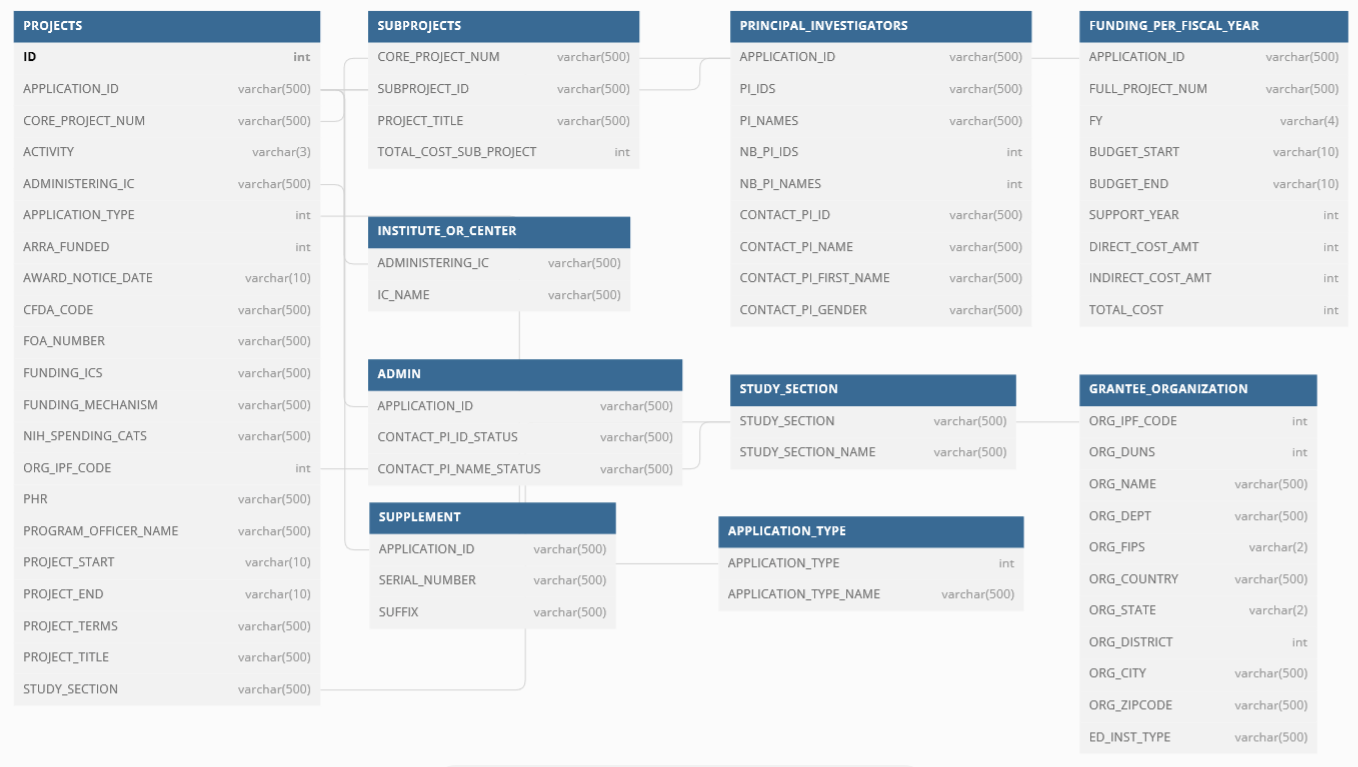

# Table creation

## Split enhanced output file into different tables according to database design

In [6]:
def is_not_duplicated(row):
    return row['APPLICATION_ID'] != '7916889' 
    # there was 1 duplicated application_id (supposed to be unique), so I removed both rows to prevent SQL import from crashing


def filter_columns(
    source_file, target_file, subset_headers, 
    default_row_filter=is_not_duplicated, row_filter=lambda row: True):
    
    subset_headers_set = set(subset_headers)
    
    with open(source_file, 'r', encoding=ENCODING, newline=NEWLINE) as csv_file_descriptor:
        reader = csv.DictReader(csv_file_descriptor, delimiter=DELIMITER)

        with open(target_file, 'w', encoding=ENCODING, newline=NEWLINE) as output_file:
            writer = csv.DictWriter(output_file, fieldnames=subset_headers, delimiter=DELIMITER)
            writer.writeheader()

            for row in reader:
                if default_row_filter(row) == False:
                    continue
                    
                if row_filter(row) == False:
                    continue
                
                subset_row = {}
                for key, value in row.items():
                    if key in subset_headers_set:
                        subset_row[key] = value
                writer.writerow(subset_row)

In [7]:
# TABLE PROJECTS
filter_columns(ENHANCED_FILE, TABLE_DIR + 'PROJECTS.tsv', [
    APPLICATION_ID, # use as primary key
    CORE_PROJECT_NUM, 
    ACTIVITY, 
    ADMINISTERING_IC, 
    APPLICATION_TYPE, 
    ARRA_FUNDED, 
    AWARD_NOTICE_DATE, 
    CFDA_CODE, 
    FOA_NUMBER, 
    FUNDING_ICS, 
    FUNDING_MECHANISM, 
    NIH_SPENDING_CATS, 
    ORG_IPF_CODE, 
    PHR, 
    PROGRAM_OFFICER_NAME, 
    PROJECT_START, 
    PROJECT_END, 
    PROJECT_TERMS, 
    PROJECT_TITLE,  
    STUDY_SECTION])

In [7]:
# TABLE SUBPROJECTS
filter_columns(ENHANCED_FILE, TABLE_DIR + 'SUBPROJECTS.tsv', [
    CORE_PROJECT_NUM,
    SUBPROJECT_ID, 
    PROJECT_TITLE, 
    TOTAL_COST_SUB_PROJECT], 
                 row_filter=lambda row: row[SUBPROJECT_ID] != "" and row[SUBPROJECT_ID] is not None)

In [8]:
# TABLE APPLICATION_TYPE
filter_columns(ENHANCED_FILE, TABLE_DIR + 'APPLICATION_TYPE.tsv', [
    APPLICATION_TYPE, 
    APPLICATION_TYPE_NAME])

In [9]:
# TABLE PRINCIPAL_INVESTIGATORS
filter_columns(ENHANCED_FILE, TABLE_DIR + 'PRINCIPAL_INVESTIGATORS.tsv', [
    APPLICATION_ID, 
    PI_IDS, 
    PI_NAMES, 
    NB_PI_IDS, 
    NB_PI_NAMES, 
    CONTACT_PI_ID, 
    CONTACT_PI_NAME, 
    CONTACT_PI_FIRST_NAME, 
    CONTACT_PI_GENDER])

In [10]:
# TABLE FUNDING_PER_FISCAL_YEAR
filter_columns(ENHANCED_FILE, TABLE_DIR + 'FUNDING_PER_FISCAL_YEAR.tsv', [
    APPLICATION_ID, 
    FULL_PROJECT_NUM, 
    FY, 
    BUDGET_START, 
    BUDGET_END, 
    SUPPORT_YEAR, 
    DIRECT_COST_AMT, 
    INDIRECT_COST_AMT, 
    TOTAL_COST])

In [11]:
# TABLE GRANTEE_ORGANIZATION
filter_columns(ENHANCED_FILE, TABLE_DIR + 'GRANTEE_ORGANIZATION.tsv', [
    ORG_IPF_CODE, 
    ORG_DUNS, 
    ORG_NAME, 
    ORG_DEPT, 
    ORG_FIPS, 
    ORG_COUNTRY, 
    ORG_STATE, 
    ORG_DISTRICT, 
    ORG_CITY, 
    ORG_ZIPCODE, 
    ED_INST_TYPE])

In [12]:
# TABLE INSTITUTE_OR_CENTER
filter_columns(ENHANCED_FILE, TABLE_DIR + 'INSTITUTE_OR_CENTER.tsv', [
    ADMINISTERING_IC, 
    IC_NAME])

In [13]:
# TABLE STUDY_SECTION
filter_columns(ENHANCED_FILE, TABLE_DIR + 'STUDY_SECTION.tsv', [
    STUDY_SECTION, 
    STUDY_SECTION_NAME])

In [14]:
# TABLE SUPPLEMENT - for useless fields that we still want to keep
filter_columns(ENHANCED_FILE, TABLE_DIR + 'SUPPLEMENT.tsv', [
    APPLICATION_ID,
    SERIAL_NUMBER,
    SUFFIX])

In [15]:
# TABLE ADMIN - for more information on the output of the gender identification
filter_columns(ENHANCED_FILE, TABLE_DIR + 'ADMIN.tsv', [
    APPLICATION_ID,
    CONTACT_PI_ID_STATUS, 
    CONTACT_PI_NAME_STATUS])

## QA

In [8]:
# Take a look at the different tables to make sure they contain the right data
test_df = pd.read_csv(TABLE_DIR + 'PROJECTS.tsv', delimiter=DELIMITER, encoding=ENCODING, low_memory=False)
test_df.head()

,APPLICATION_ID,CORE_PROJECT_NUM,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,CFDA_CODE,FOA_NUMBER,FUNDING_ICS,FUNDING_MECHANISM,NIH_SPENDING_CATS,ORG_IPF_CODE,PHR,PROGRAM_OFFICER_NAME,PROJECT_START,PROJECT_END,PROJECT_TERMS,PROJECT_TITLE,STUDY_SECTION
0,10229388,P01AI060699,P01,AI,5.0,N,07/23/2021,NaN,PAR-13-254,NIAID:88798\,NON-SBIR/STTR RPGS,NaN,3972901.0,NaN,NaN,07/01/2004,07/31/2022,Advisory Committees; Animals; Budgets; Cell Co...,Administrative Core,ZAI1
1,10229500,P01AI089618,P01,AI,5.0,N,07/27/2021,NaN,PAR-13-254,NIAID:390000\,NON-SBIR/STTR RPGS,NaN,1504801.0,NaN,NaN,08/01/2011,07/31/2022,Animal Model; Animals; Antibodies; Antigens; A...,Virology Core,ZAI1
2,10234175,P20GM104316,P20,GM,5.0,N,08/12/2021,NaN,PAR-19-312,NIGMS:217850\,RESEARCH CENTERS,NaN,2076701.0,NaN,NaN,09/01/2014,06/30/2025,Address; Affinity; Amino Acids; Antibiotics; B...,Molecular mechanisms supporting bacterial surv...,ZGM1
3,10107767,R21AI148877,R21,AI,5.0,N,01/29/2021,855,PA-19-053,NIAID:236250\,NON-SBIR/STTR RPGS,NaN,9083901.0,Project Narrative / Relevance Tissue-resident ...,"VAZQUEZ-MALDONADO, NANCY",02/07/2020,01/31/2022,Address; Anti-Inflammatory Agents; base; Bioin...,Role of ontogeny and niche on human macrophage...,III
4,10144347,R01AG058549,R01,AG,5.0,N,05/07/2021,866,PAR-15-356,NIA:721359\,NON-SBIR/STTR RPGS,NaN,2059802.0,"PROJECT NARRATIVE Between 2006 and 2008, we as...","ANDERSON, DALLAS",08/01/2018,04/30/2023,Abbreviations; Address; Adult; African America...,Risk factors for MCI and Dementia in a Diverse...,ZRG1


In [9]:
test_df.duplicated(subset=['APPLICATION_ID']).value_counts()

False    2621672
dtype: int64

In [10]:
test_df[test_df.duplicated(['APPLICATION_ID'], keep=False)]

,APPLICATION_ID,CORE_PROJECT_NUM,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,CFDA_CODE,FOA_NUMBER,FUNDING_ICS,FUNDING_MECHANISM,NIH_SPENDING_CATS,ORG_IPF_CODE,PHR,PROGRAM_OFFICER_NAME,PROJECT_START,PROJECT_END,PROJECT_TERMS,PROJECT_TITLE,STUDY_SECTION


## Import with Microsoft SQL Management Studio

Now, you should go talk to Mario at OST to get help with the import.

Good luck!